In [1]:
# install pip packages

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna
import joblib
import matplotlib.pyplot as plt
import numpy as np
import boto3
import sagemaker
import time
from time import gmtime, strftime, sleep
from sagemaker.feature_store.feature_group import FeatureGroup

#### EDA

Exploratory Data Analysis Summary

This dataset provides insights into cardiovascular health with key variables like **age**, **gender**, **height**, **weight**, **BMI**, and **cardiac condition** (cardio). 

- **Age** is presented in years, covering a wide age range.
- **Gender** is encoded as 1 for **Female** and 2 for **Male**.
- **BMI** is calculated as **weight (kg) / height^2 (m)**.
- **Cardiac condition** is recorded as 0 for **no disease** and 1 for **cardiac disease**.



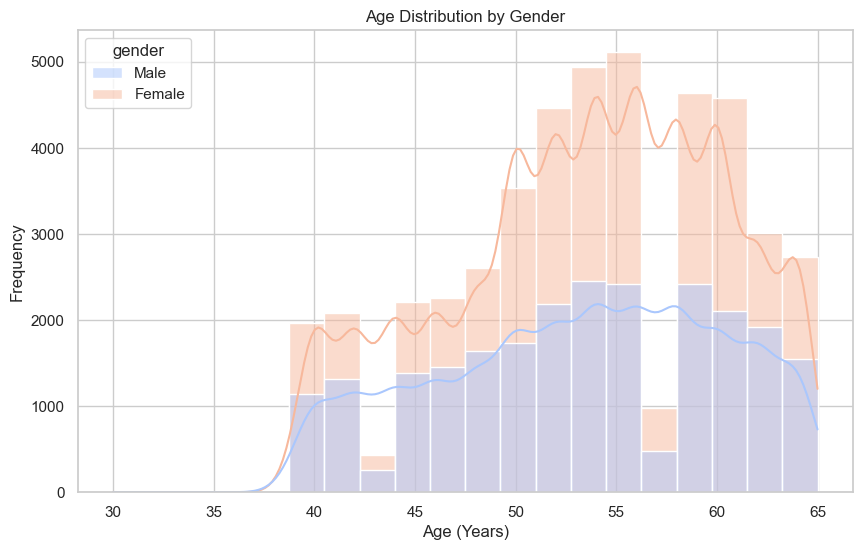

/var/folders/zr/tvl66dbj4756z6y3p0_gfv680000gn/T/ipykernel_56249/2958890998.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='height', data=data, palette='coolwarm')


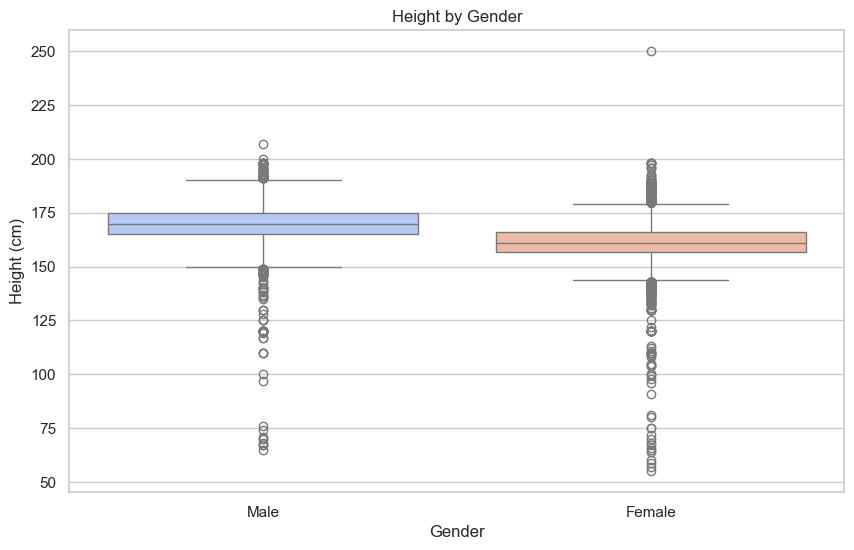

/var/folders/zr/tvl66dbj4756z6y3p0_gfv680000gn/T/ipykernel_56249/2958890998.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='weight', data=data, palette='coolwarm')


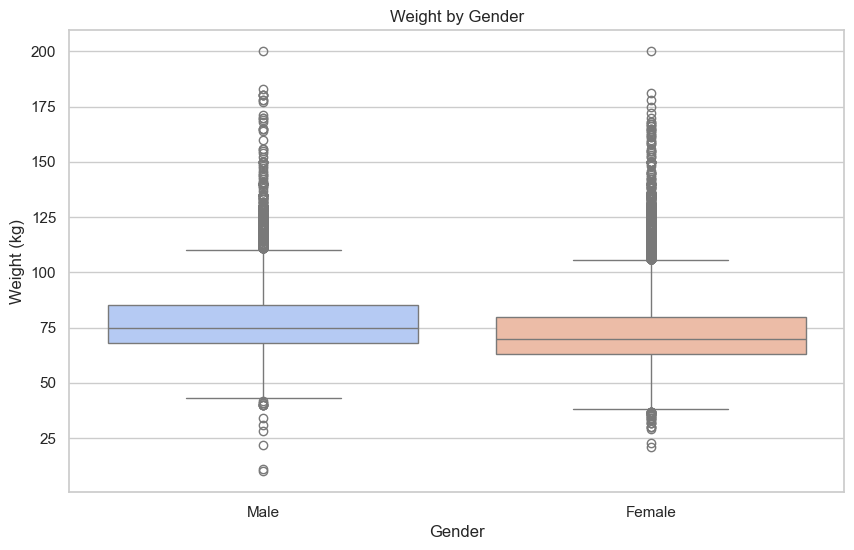

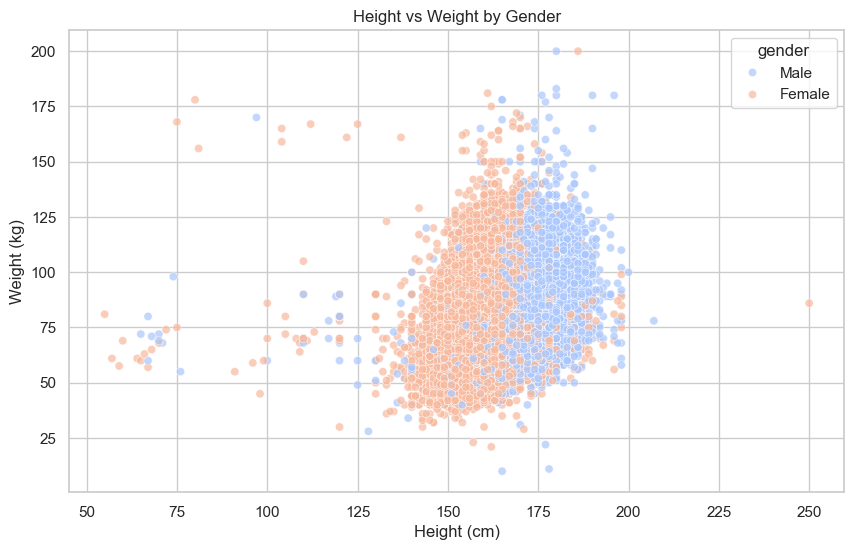

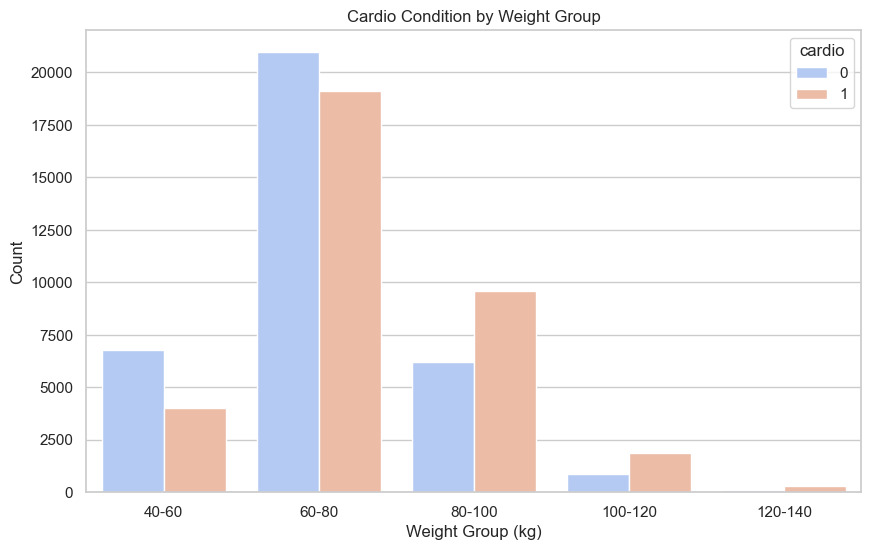

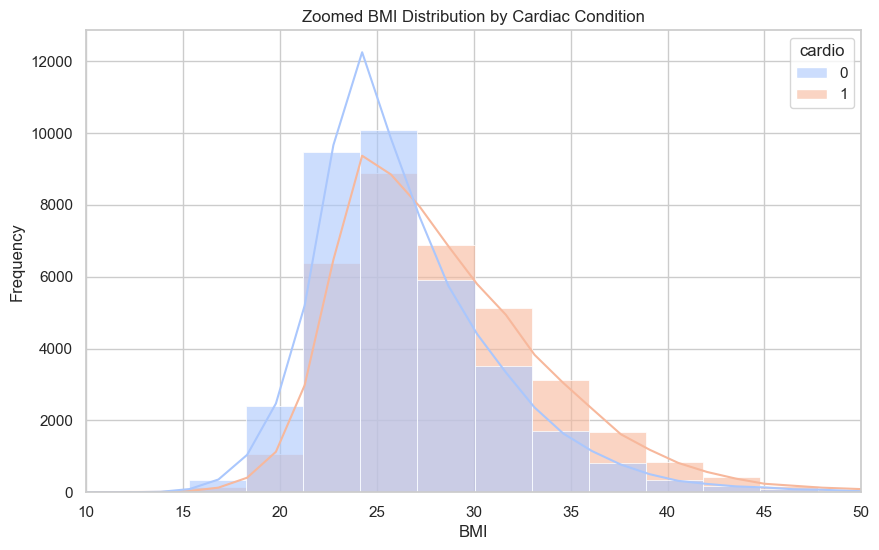

/var/folders/zr/tvl66dbj4756z6y3p0_gfv680000gn/T/ipykernel_56249/2958890998.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='BMI_category', data=data, palette='coolwarm')


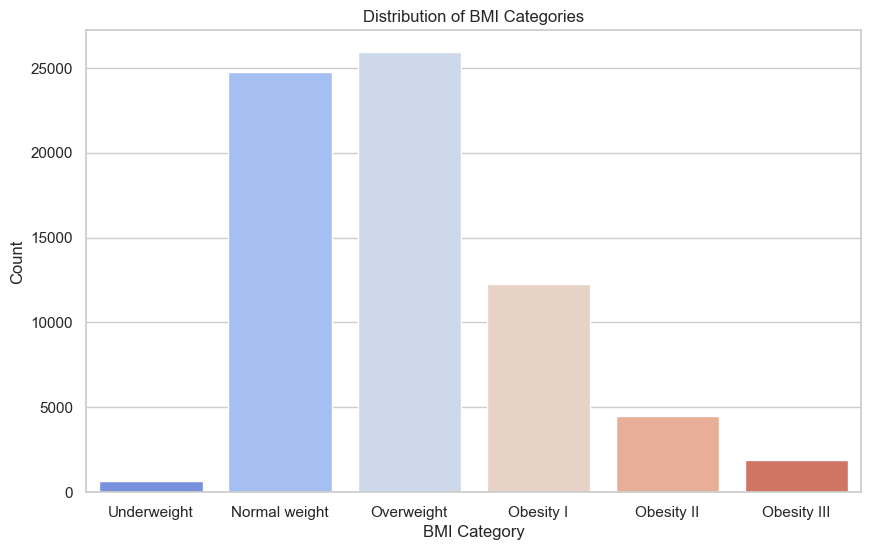

In [4]:

# Set seaborn style for beautiful visualizations
sns.set(style="whitegrid")

# Load the data
def load_data():
    return pd.read_csv('data/cardio_train.csv', sep=';')

data = load_data()

# Data Preprocessing
data['age_years'] = (data['age'] / 365).round().astype(int)
data['gender'] = data['gender'].map({1: 'Female', 2: 'Male'})
data['height_m'] = data['height'] / 100  # Convert height from cm to meters
data['BMI'] = data['weight'] / (data['height_m'] ** 2)

# Summary of the data
print("Exploratory Data Analysis Summary")
print("""
This dataset provides insights into cardiovascular health with key variables like **age**, **gender**, **height**, **weight**, **BMI**, and **cardiac condition** (cardio). 

- **Age** is presented in years, covering a wide age range.
- **Gender** is encoded as 1 for **Female** and 2 for **Male**.
- **BMI** is calculated as **weight (kg) / height^2 (m)**.
- **Cardiac condition** is recorded as 0 for **no disease** and 1 for **cardiac disease**.
""")

# 1. Distribution of Age with KDE Plot, differentiated by gender
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='age_years', hue='gender', kde=True, bins=20, palette='coolwarm')
plt.title('Age Distribution by Gender')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')
plt.show()

# 2. Boxplot for Height by Gender
plt.figure(figsize=(10,6))
sns.boxplot(x='gender', y='height', data=data, palette='coolwarm')
plt.title('Height by Gender')
plt.xlabel('Gender')
plt.ylabel('Height (cm)')
plt.show()

# Boxplot for Weight by Gender
plt.figure(figsize=(10,6))
sns.boxplot(x='gender', y='weight', data=data, palette='coolwarm')
plt.title('Weight by Gender')
plt.xlabel('Gender')
plt.ylabel('Weight (kg)')
plt.show()

# 3. Scatter Plot for Height vs Weight, color-coded by gender
plt.figure(figsize=(10,6))
sns.scatterplot(x='height', y='weight', hue='gender', data=data, palette='coolwarm', alpha=0.7)
plt.title('Height vs Weight by Gender')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

# 4. Count of Cardio Condition by Weight Group
bins = [40, 60, 80, 100, 120, 140]
labels = ['40-60', '60-80', '80-100', '100-120', '120-140']
data['weight_group'] = pd.cut(data['weight'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
sns.countplot(x='weight_group', hue='cardio', data=data, palette='coolwarm')
plt.title('Cardio Condition by Weight Group')
plt.xlabel('Weight Group (kg)')
plt.ylabel('Count')
plt.show()

# 5. Zoomed and Granular BMI Distribution by Cardiac Condition
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='BMI', hue='cardio', kde=True, bins=100, palette='coolwarm', alpha=0.6)
plt.xlim(10, 50)
plt.title('Zoomed BMI Distribution by Cardiac Condition')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# 6. Countplot of BMI Categories
bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]
labels = ['Underweight', 'Normal weight', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']
data['BMI_category'] = pd.cut(data['BMI'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
sns.countplot(x='BMI_category', data=data, palette='coolwarm')
plt.title('Distribution of BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()


#### Preprocessing / Feature Engineering

In [5]:
# Load and preprocess the dataset
print("Loading the dataset...")
file_path = r'data/cardio_train.csv'
df = pd.read_csv(file_path, sep=";")

print("Dataset loaded successfully. Now filling missing values with the median...")
df = df.fillna(df.median())  # Fill missing values

print("Converting 'gender' column to numeric (1=male, 2=female) as needed...")
df['gender'] = df['gender'].map({1: 0, 2: 1})  # Convert gender to numeric

Loading the dataset...
Dataset loaded successfully. Now filling missing values with the median...
Converting 'gender' column to numeric (1=male, 2=female) as needed...


#### Split Data 

In [11]:
print("Splitting the data into features (X) and target (y)...")
X = df.drop(columns=['cardio'])  # Features
y = df['cardio']  # Target variable

print("Performing train-test split with 80% training and 20% testing...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train-test split completed. Training set size:", X_train.shape, ", Testing set size:", X_test.shape)

Splitting the data into features (X) and target (y)...
Performing train-test split with 80% training and 20% testing...
Train-test split completed. Training set size: (56000, 12) , Testing set size: (14000, 12)


In [ ]:
# convert test / train into format needed to upload in s3 (csv?) export to data/


### CI/CD Load Data

In [ ]:
# todo change path to real data in s3
local_path_train = "data/cardio-train.csv"
local_path_test = "data/cardio-test.csv"

base_uri = f"s3://{bucket}/train/"
train_input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_train,
    desired_s3_uri=base_uri,
)
print(train_input_data_uri)

base_uri = f"s3://{bucket}/test/"
batch_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path_test,
    desired_s3_uri=base_uri,
)
print(batch_data_uri)

In [ ]:
# Define pipeline arameters

from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputData",
    default_value=train_input_data_uri,
)
batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)
mse_threshold = ParameterFloat(name="Accuracy", default_value=0.70)

#### Create processing script 
this is the programatic approach to write file to code/preprocessing.py 

In [ ]:
%%writefile code/preprocessing.py
import argparse
import os
import requests
import tempfile

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Since we get a headerless CSV file, we specify the column names here.
feature_columns_names = [
    "sex",
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
]
label_column = "rings"

feature_columns_dtype = {
    "sex": str,
    "length": np.float64,
    "diameter": np.float64,
    "height": np.float64,
    "whole_weight": np.float64,
    "shucked_weight": np.float64,
    "viscera_weight": np.float64,
    "shell_weight": np.float64,
}
label_column_dtype = {"rings": np.float64}


def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z


if __name__ == "__main__":
    base_dir = "/opt/ml/processing"

    df = pd.read_csv(
        f"{base_dir}/input/cardio-train.csv",
        # header=True,
        # names=feature_columns_names + [label_column],
        # dtype=merge_two_dicts(feature_columns_dtype, label_column_dtype),
    )

    numeric_features = list(feature_columns_names)
    
    # numeric_features = list(feature_columns_names)
    # numeric_features.remove("sex")

    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    categorical_features = ["sex"]
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # y = df.pop("rings")
    # X_pre = preprocess.fit_transform(df)
    # y_pre = y.to_numpy().reshape(len(y), 1)

    # X = np.concatenate((y_pre, X_pre), axis=1)

    # np.random.shuffle(X)

    # train, validation, test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])

    # pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
    # pd.DataFrame(validation).to_csv(
    #     f"{base_dir}/validation/validation.csv", header=False, index=False
    # )
    # pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

    # Splitting data
    print("Splitting the data into features (X) and target (y)...")
    X = df.drop(columns=['cardio'])  # Features
    y = df['cardio']  # Target variable

    print("Performing train-test split with 80% training and 20% testing...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Train-test split completed. Training set size:", X_train.shape, ", Testing set size:", X_test.shape)
    

    

### AWS Config to Create Feature Store

In [ ]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [13]:
# inspect data frame for na values
display(X.head())
print(X.shape)
# final_df = final_df.dropna()
print(X.isna().sum())
print("target variable (cardio) na sum:", y.isna().sum())


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,1,168,62.0,110,80,1,1,0,0,1
1,1,20228,0,156,85.0,140,90,3,1,0,0,1
2,2,18857,0,165,64.0,130,70,3,1,0,0,0
3,3,17623,1,169,82.0,150,100,1,1,0,0,1
4,4,17474,0,156,56.0,100,60,1,1,0,0,0


(70000, 12)
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64
0


#### Define feature group

In [ ]:
patient_feature_group_name = "patient-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

patient_feature_group = FeatureGroup(
    name=patient_feature_group_name, sagemaker_session=sess
)

def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if pd.api.types.is_object_dtype(data_frame[label]):
            data_frame[label] = data_frame[label].astype("string")
    return data_frame

final_df = cast_object_to_string(X)

record_identifier_feature_name = "id"
event_time_feature_name = "event_time" # needed for FEATURE GROUP
current_time_sec = int(round(time.time()))
final_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(X), dtype="float64"
)

final_df['event_time'] = final_df['event_time'].fillna(current_time_sec)

print(final_df['event_time'].isnull().sum()) 
display(final_df.head())

# Load feature definitions into the feature group
patient_feature_group.load_feature_definitions(data_frame=final_df)

#### Create feature group in sagemaker feature store

In [ ]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

s3_private_data_path = "s3://{}/feature_groups/".format(bucket)

patient_feature_group.create(
    s3_uri= s3_private_data_path,
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=patient_feature_group)

In [ ]:
# Validate feature group
patient_feature_group.describe()
sagemaker_client.list_feature_groups()

In [ ]:
# Injest / Put Records into feature group 
patient_feature_group.ingest(data_frame=final_df, max_workers=5, wait=True)

In [ ]:
# retreive a record from the online store
# Should be: 0	0	18393	1	168	62.0	110	80	1	1	0	0	1
record_identifier_value = '0'

featurestore_runtime.get_record(
    FeatureGroupName=patient_feature_group_name,
    RecordIdentifierValueAsString=record_identifier_value,
)

In [ ]:
# Clean up feature group
patient_feature_group.delete()

#### Create Model Cards

### Configure CloudWatch 

#### Create and upload baseline Metrics

#### Setup Monitoring Metrics

### CI/CD